In [3]:
import pandas as pd
import xml.etree.ElementTree as et
import shutil
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
import pyproj

Fuente de información **centrodedescargas.cnig.es**:

Fuente: *https://centrodedescargas.cnig.es/CentroDescargas/img/descargar_cdd.png*

In [18]:
shutil.unpack_archive("input/lineas_limite.zip", "./input")

## Importamos shapefiles

Peninsula, baleares y canarias

In [20]:
crs=CRS('EPSG:4258')

shp_areas = pd.concat([gpd.read_file("input/SHP_ETRS89/recintos_municipales_inspire_peninbal_etrs89/recintos_municipales_inspire_peninbal_etrs89.shp"),
                       gpd.read_file("input/SHP_REGCAN95/recintos_municipales_inspire_canarias_regcan95/recintos_municipales_inspire_canarias_regcan95.shp").to_crs('ETRS89')
                      ])
shp_areas["codine"] = shp_areas.apply(lambda x: int(str(x["NATCODE"])[-5:]), axis=1)
shp_areas.head(2)

,INSPIREID,COUNTRY,NATLEV,NATLEVNAME,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry,codine
0,ES.IGN.BDDAE.34010404001,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34010404001,Abla,ES6,ES61,ES611,"POLYGON ((-2.78452 37.09350, -2.78410 37.09476...",4001
1,ES.IGN.BDDAE.34010404002,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34010404002,Abrucena,ES6,ES61,ES611,"POLYGON ((-2.88985 37.09212, -2.88953 37.09249...",4002


Primer plot

/tmp/ipykernel_56851/902561835.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_areas.centroid.plot(ax=ax, color='red', markersize=5)


<Axes: >

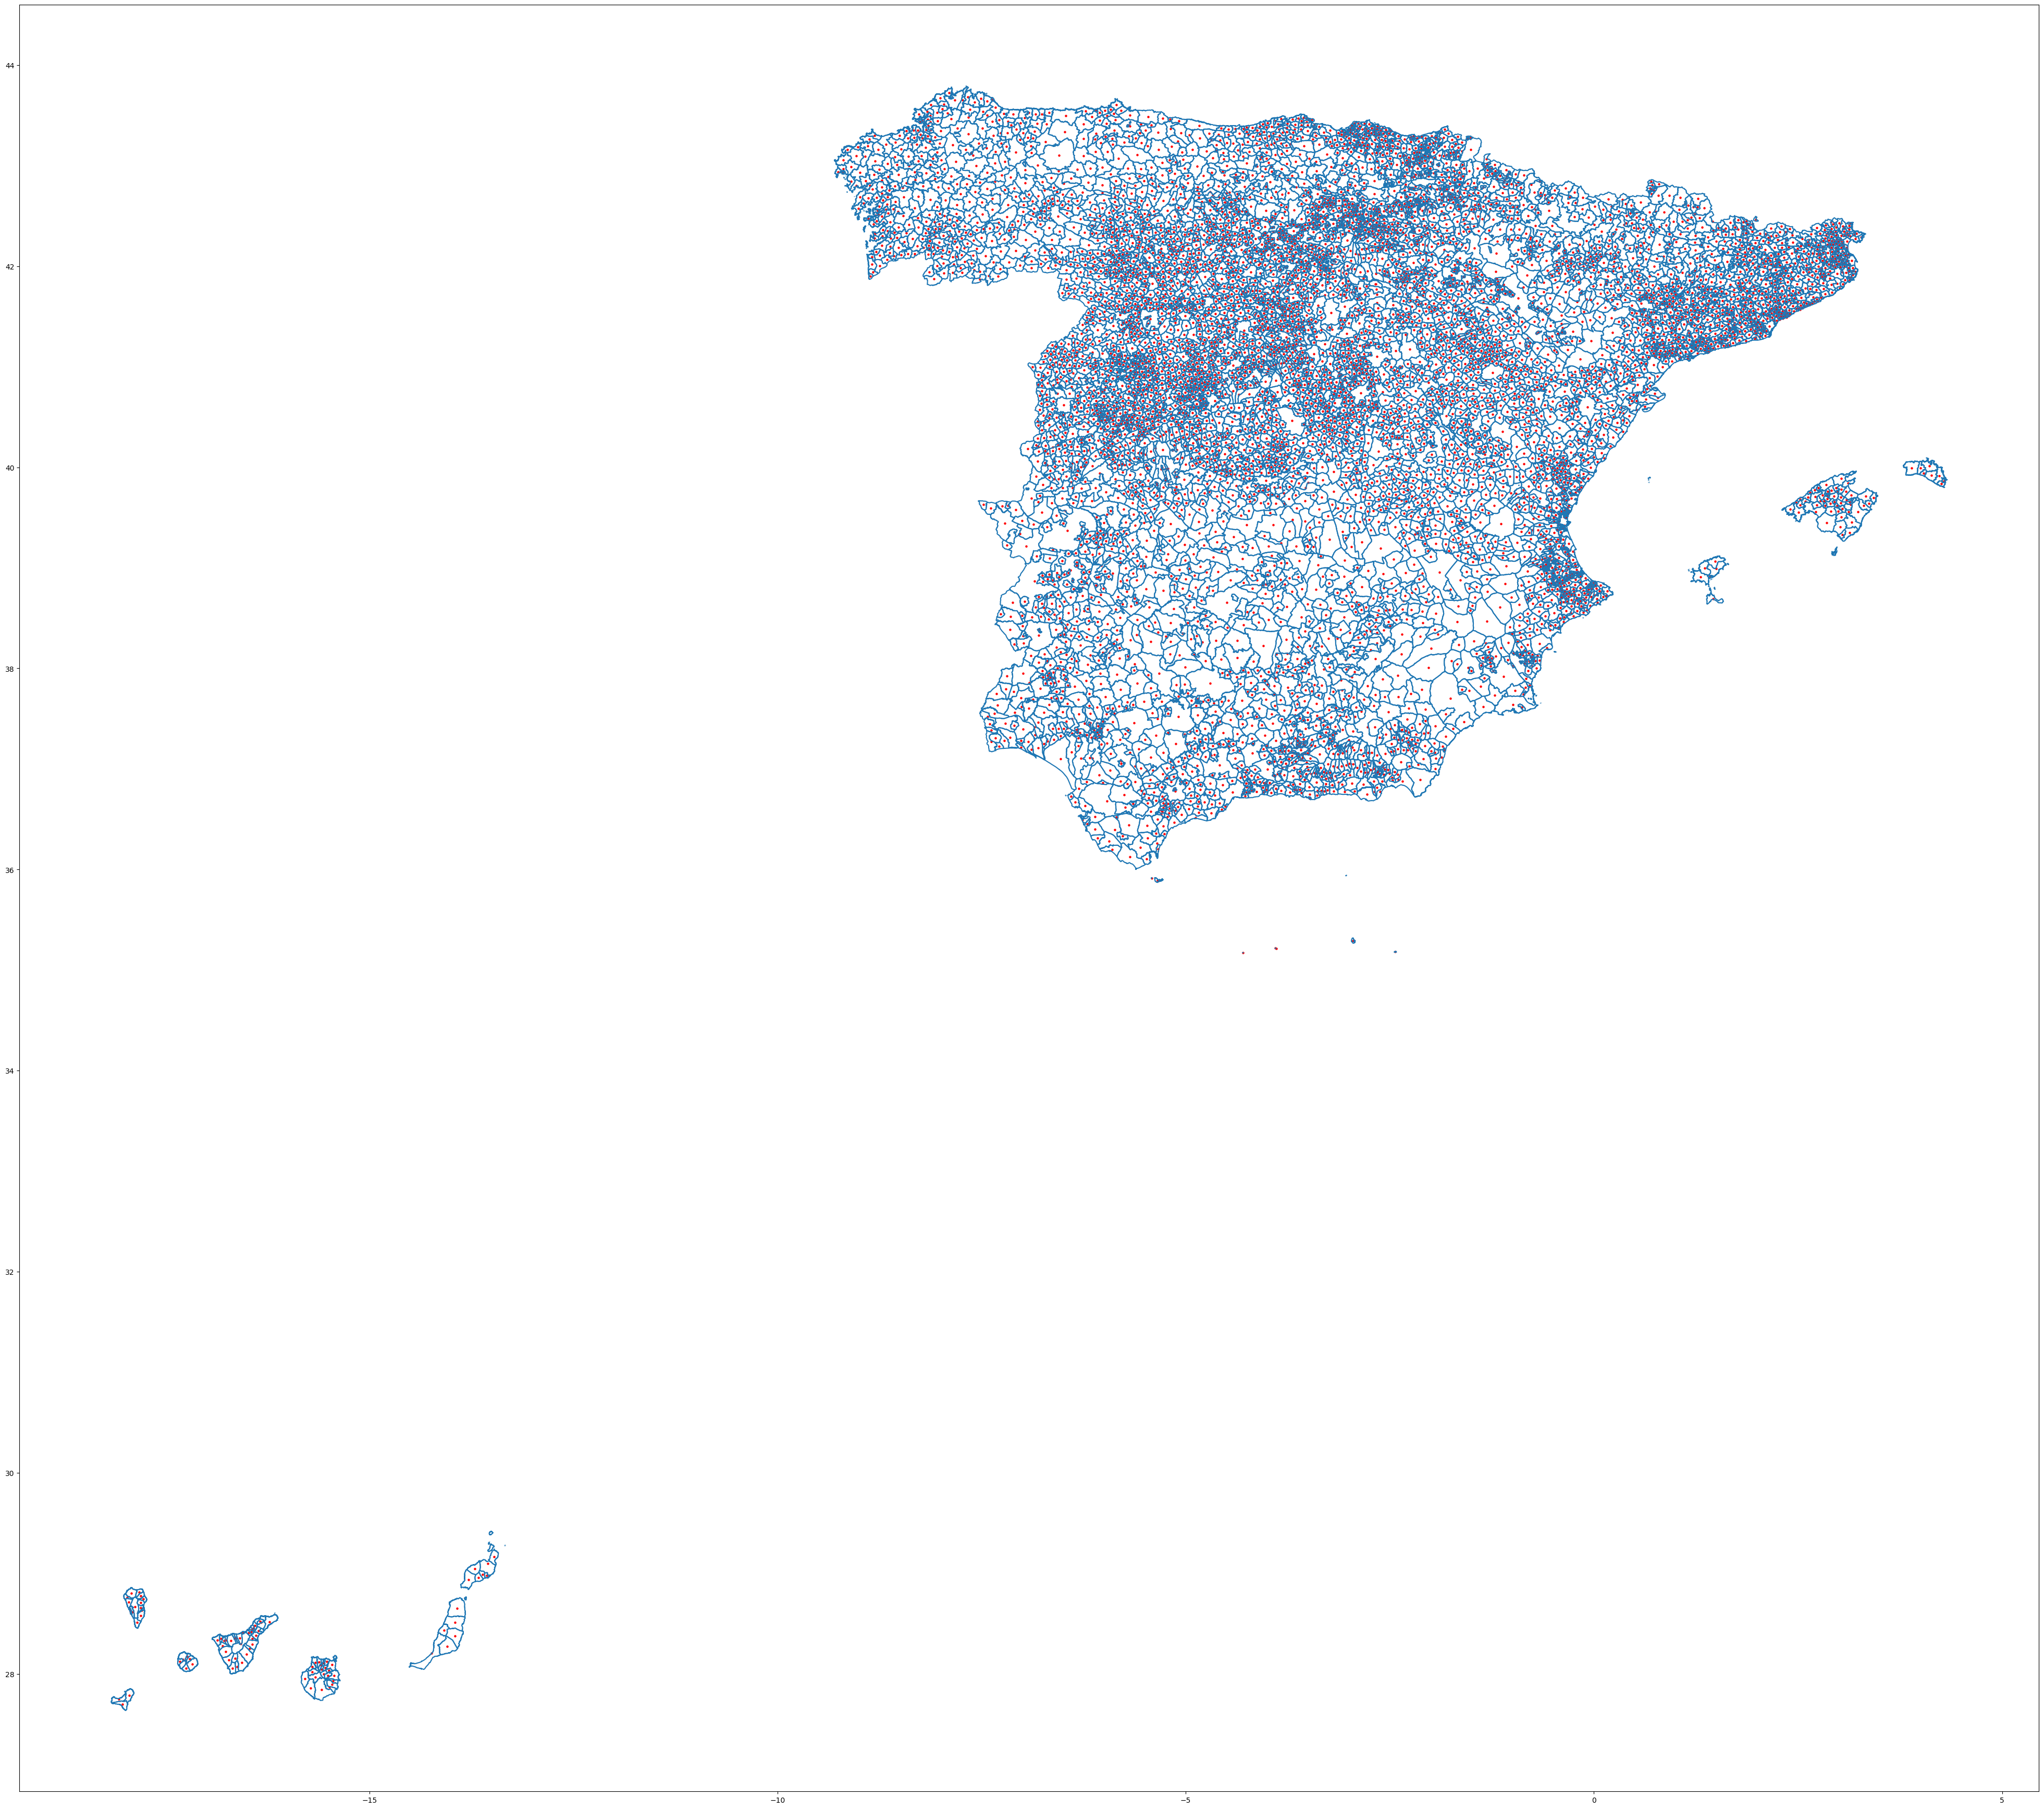

In [21]:
fig, ax = plt.subplots(figsize=(50, 50))
shp_areas.boundary.plot(ax=ax)
shp_areas.centroid.plot(ax=ax, color='red', markersize=5)

In [22]:
shp_areas.to_file("output/gpd_municipio.shp", driver='ESRI Shapefile')


## Generamos fichero con los municipios que colindan con otros municipios (Adjacency table)
Puede ser útil para hacer suavizados por cercanía.

In [ ]:
adyTb = pd.concat([pd.DataFrame(shp_fronteras.NAME_BOUND.str.split('#').to_list(),columns=["base","colindante"]),
                   pd.DataFrame(shp_fronteras.NATIONALCO.str.split(pat="[MT]").to_list(), columns=["0","idBase",'idColindante',"3"])[["idBase","idColindante"]].astype('int')
                  ], axis=1)
adyTb =pd.concat([adyTb,
                  adyTb.rename(columns={"base":"colindante","idBase":"idColindante",
                                        "colindante":"base","idColindante":"idBase"
                                       })
                 ], axis=0)

In [ ]:
pd.merge(adyTb.groupby(["idBase","base"])["colindante"].apply(list).to_frame(),
         adyTb.groupby(["idBase","base"])["idColindante"].apply(list).to_frame(),
        left_index=True,right_index=True).\
    reset_index().\
    set_index("idBase").\
    to_pickle("./output/adyacency_table.pkl")

## Generamos fichero con centroide por municipios y distancia entre municipios
Sirve para calcular factores relacionados con distancia entre municipios.

In [ ]:
shp_areas = pd.concat([shp_areas[["NATCODE","NAMEUNIT","geometry"]],
           shp_areas.geometry.to_crs("epsg:2062").centroid.to_frame("centroid")],
         axis=1)
shp_areas["NATCODE"] = shp_areas.NATCODE.astype(int)
shp_areas.set_index("NATCODE",inplace=True)
shp_areas.to_crs("epsg:32633",inplace=True)
shp_areas.head()

In [ ]:
rgDist = [5,10,20,30]
def municipiosCercanos(shp_areas):
    dictReturn = dict()
    cont = 0
    for i in rgDist:
        dictReturn = {**dictReturn, "dist" + str(i): []}

    for g in shp_areas.centroid:
        dist = shp_areas.centroid.distance(g)/1000

        for i in rgDist:
            dictReturn["dist" + str(i)].append(shp_areas.index[dist < i].to_list())
        
        if cont%1000 ==0:
            print(f"Nº de municipios analizados {cont}")
        cont += 1
        
    return dictReturn

In [ ]:
dfMunicipiosCercanos = pd.DataFrame(municipiosCercanos(shp_areas))

In [ ]:
dfMunicipiosCercanos.set_index(shp_areas.index, inplace=True)
dfMunicipiosCercanos.head()

Añadimos los campos calculados a la tabla shp_areas:

In [ ]:
pd.concat([shp_areas,
           dfMunicipiosCercanos
          ], axis=1).to_pickle("./output/distance_table.pkl")

In [ ]:
pd.read_pickle("./output/distance_table.pkl")